# Import Packages

In [1]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

/mnt/c/Users/QUAN/Desktop/img_seg/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Directories

In [2]:
SIZE_DICT = {"small": "b",
             "medium": "l",
             "large": "h"}

MODEL_SIZE = "small"
MODEL_TYPE = SIZE_DICT[MODEL_SIZE]
SAM_CKPT_PATH = os.path.join("..","artifacts","pretrained", f"sam_vit_{MODEL_TYPE}.pth")

# Utility

In [4]:
def draw_bbox(image, x_min, y_min, x_max, y_max, linecolor = (0, 0, 255), linewidth = 2):
    img_copy = copy.copy(image)
    cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), linecolor, linewidth)
    return img_copy

def draw_polygon(image: np.ndarray, points, linecolor = (0, 0, 255), linewidth = 2):

    if isinstance(points, list):
        points = np.array(points, dtype=np.uint8)
    points = points.reshape((-1, 1, 2))
    isClosed = True

    cv2.polylines(image, [points], isClosed, linecolor, thickness = linewidth)

    return image

# Test Prototypes

### Generate all masks without prompts

In [5]:
sam = sam_model_registry["vit_"+MODEL_TYPE](checkpoint=SAM_CKPT_PATH)
mask_generator = SamAutomaticMaskGenerator(sam)
mask_predictor = SamPredictor(sam)

In [6]:
sample_img_path = os.path.join("..","data","sample_imgs","L3_1.jpg")
sample_img = Image.open(sample_img_path)
sample_img = np.array(sample_img, dtype = np.uint8)

In [7]:
masks = mask_generator.generate(sample_img)

In [ ]:
masks[1]

#### Individual Masks

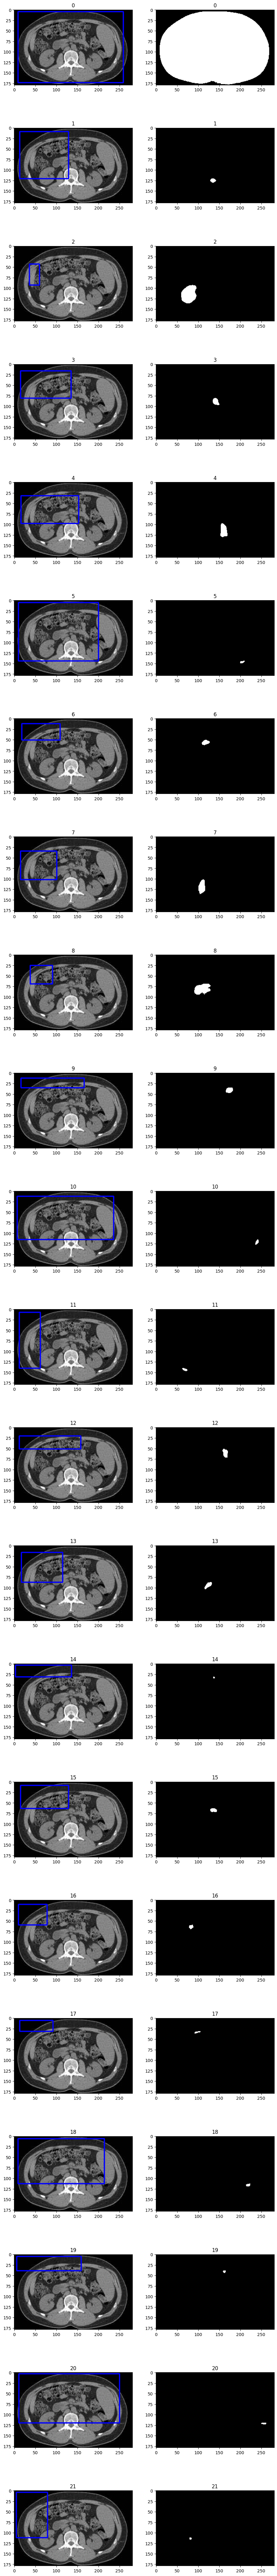

In [44]:
mask_no = len(masks)
plt.figure(figsize=(11, 5 * mask_no))
plot_idx = 1
for i in range(mask_no):
    plt.subplot(mask_no, 2, plot_idx)
    x_min, y_min, x_max, y_max = masks[i]["bbox"]
    img_with_bbox = draw_bbox(sample_img, x_min, y_min, x_max, y_max)
    plt.imshow(img_with_bbox)
    plt.title(str(i))
    plot_idx += 1
    plt.subplot(mask_no, 2, plot_idx)
    mask = masks[i]['segmentation'].astype(float)
    mask = np.stack([mask, mask, mask], axis = 2)
    plt.imshow(mask)
    plot_idx += 1
    plt.title(str(i))

#### Combined Mask

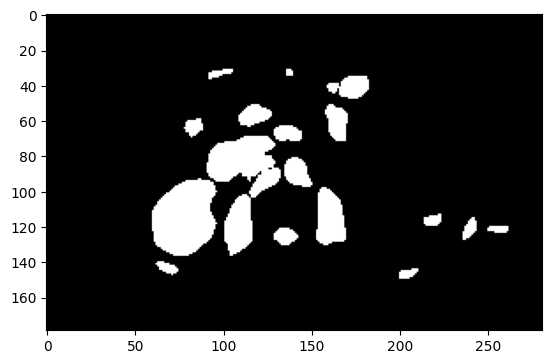

In [47]:
plt.figure()
mask_no = len(masks)
h, w, _ = sample_img.shape
mask = np.zeros(shape = (h, w))
for i in range(1, mask_no):
    mask += masks[i]["segmentation"]

combined_mask = (mask > 0).astype(float)
combined_mask = np.stack([combined_mask, combined_mask, combined_mask], axis = 2)
plt.imshow(combined_mask)

## Test Predictor with Prompt

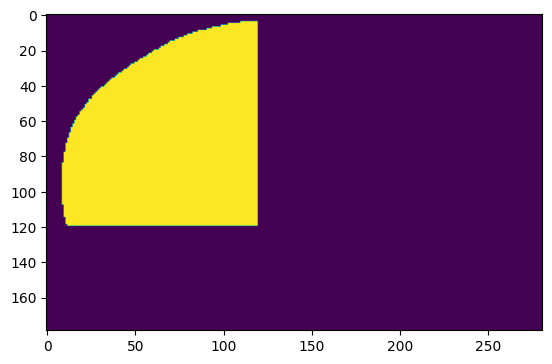

In [11]:
half_mask = masks[0]["segmentation"]
half_mask[:, 120:] = 0

plt.imshow(half_mask)

In [12]:
mask_predictor.set_image(sample_img)
masks, scores, logits = mask_predictor.predict(
    mask_input = half_mask,
    multimask_output = True
)

IndexError: too many indices for tensor of dimension 2